# Configurations

https://www.tensorflow.org/tutorials/generative/pix2pix

In [4]:
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from utils import *

import tensorflow as tf
import os
import pathlib 
import time
import datetime

import warnings
warnings.filterwarnings('ignore')

# Path to each folder and files
calibra = 'dataset/meas_14_7/data/DATA_MACHINE_7-14/MEAS_1'  # path to
calibra_pairs = 'dataset/meas_14_7/calibration/calibration_15_7'  # path to 
pairs_5200 = 'dataset/meas_7_7/procIMGs'
pairs_1100 = 'dataset/meas_7_7/procIMGs_2'

# Data Loading

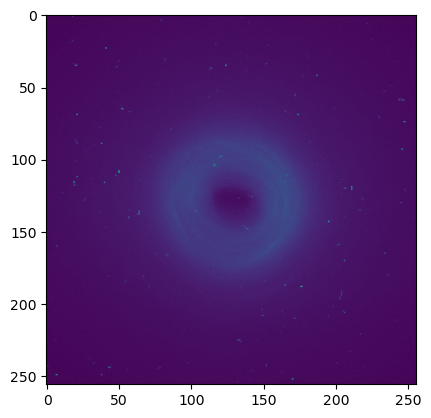

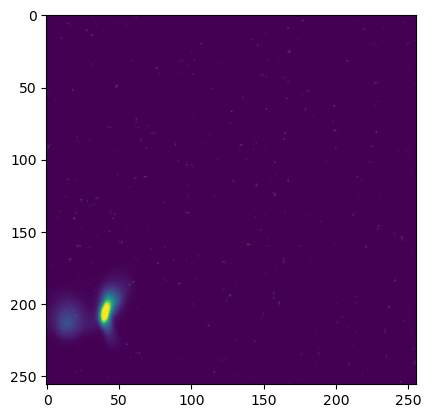

In [2]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_png(image)
    image = image[:, :, :3]  # RGBA to RGB

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image 
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image


inp, re = load(pairs_5200 + '/10.png')
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

# Data Preprocessing

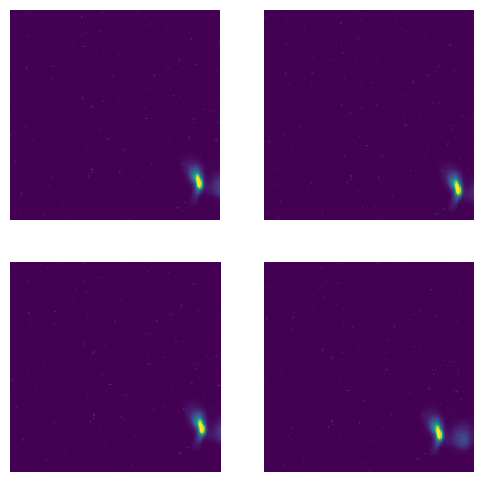

In [3]:
# The facade training set consist of 400 images
# BUFFER_SIZE = 400

# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256


# Building data pipline for data augmentation.

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]


@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256  (these two steps equivlant to shift the image)
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
    # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image



# test one image sample (for data augmentation)
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
#     plt.imshow(rj_inp / 255.0)
    plt.imshow(rj_re / 255.0)
    plt.axis('off')
plt.show()


In [4]:
# load the dataset from folders

def load_image_train(image_file):
    input_image, real_image = load(image_file)
    # input_image, real_image = random_jitter(input_image, real_image)  # fiber speckle pattern might not need random jitter
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image


def load_image_test(image_file):  
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)  # resize part for training set is in random_crop function
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image




# train_dataset = tf.data.Dataset.list_files(pairs_5200 + '/*.png')
# BUFFER_SIZE = len(train_dataset)
# train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# train_dataset = train_dataset.batch(BATCH_SIZE)


# test_dataset = tf.data.Dataset.list_files(pairs_1100 + '/*.png')
# test_dataset = test_dataset.map(load_image_test)
# test_dataset = test_dataset.batch(BATCH_SIZE)

# print(f"read training dataset samples: {len(train_dataset)}, testset samples: {len(test_dataset)}")


train_size = 0.8  # Let's say 80% for training

# Load your dataset
file_list_dataset = tf.data.Dataset.list_files(pairs_1100 + '/*.png')
file_list_dataset = file_list_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
num_files = len(file_list_dataset)

# Shuffle the dataset
shuffled_dataset = file_list_dataset.shuffle(num_files)

# Calculate the number of files in each split
num_train = int(train_size * num_files)

# Define the datasets
train_dataset = shuffled_dataset.take(num_train)
test_dataset = shuffled_dataset.skip(num_train)
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

print(f"read training dataset samples: {len(train_dataset)}, testset samples: {len(test_dataset)}")

read training dataset samples: 878, testset samples: 220


## Using official original dataset (Optional)

# Model Construction (pix2pix)

https://www.tensorflow.org/tutorials/generative/pix2pix

In [5]:
# build the generator (U-net) downsampler (encoder part)

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result


down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)



(1, 128, 128, 3)


In [6]:
# build the upsampler (decoder part)

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())

    return result


up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


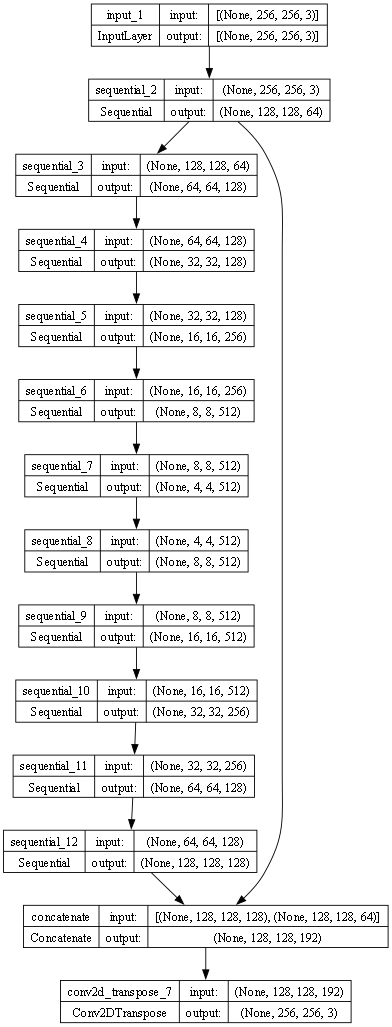

In [7]:
'''
define the Generator structure, plotting the model graph
'''

def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(128, 4),  # (batch_size, 32, 32, 256)
    downsample(256, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs # x is the temp variable to go through the list.

    # Downsampling through the model
    skips = []
    for down in down_stack:  # connnected in forward sequence
        # if the first layer is the input x, then the ouput of second layer can be considered as f(x)
        # similarly, the thrid layer is g(f(x)), and this will corresponde as the input of next layer.
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        
    x = tf.keras.layers.Concatenate()([x, skip])  # only skip connect one
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


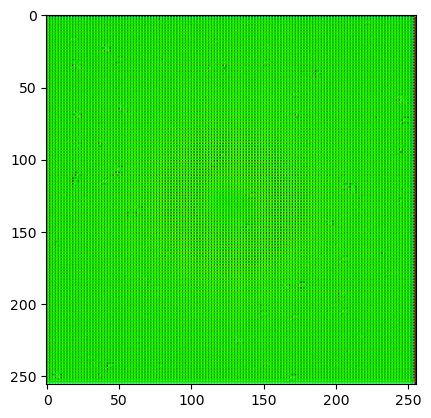

In [9]:
# using one image to test the Generator

gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [10]:
# Define the Generator Loss function for training

LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

# the loss of the generator contains two parts, the first one is the Pixel level mean absolute error, it is scaled and 
# combined with the discriminator loss using a lambda as the total loss for updating the generator.

In [11]:
'''
define the Discriminator structure (PatchGAN classifier), plotting the model graph
'''

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)  concatenate these 2 inputs together.

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

'''
It is said: Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image.
Because there are three conv2D layer, each one has stride of 2, which means the accumulative effect compare the last layer 
(30x30) to the original image (256x256) is scaled by 8
''';

TensorShape([1, 30, 30, 1])

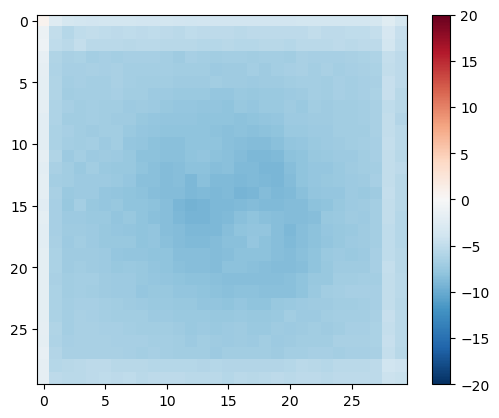

In [12]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

'''
Notice: The output of Discriminator is a matrix of 30x30 instead of a probability score as a binary classifier, is because
the Discriminator used here is a 'PatchGAN'
PatchGAN Design: Instead of assessing an entire image as a whole, a PatchGAN classifies patches of the image as real or fake. 
The idea is that if each patch is classified as real, then the entire image is likely to be real as well.
So the entire image is divided into blocks, and PatchGAN will define (output) whether it think each blocks is real or not.
The foundamental idea is the same, just on a block-wise rather than image-wise
The discriminator could give a more detailed accessment to different parts of the image. And an average value can still be 
calculated if neccessary.
'''
disc_out.shape

In [13]:
'''Define the loss function for the Discriminator'''

# notic, disc_real_output is the output of the discriminator, in this case, is a 30x30 map.
def discriminator_loss(disc_real_output, disc_generated_output):
    # this will output a single value represent the average over the entire map
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output) 
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


'''
The discriminator will be run twice each epoch, first run will be given input of [input_image, target] as 'disc_real_output',
and then [input_image, gen_output] as 'disc_generated_output'.
In my case, the input_image is the speckle pattern, the target is the original image corresponding to the speckle pattern.
the gen_output is the Generator's output based on the input speckle pattern.
Basically the Loss consists of both the discriminator see real pair of data and the generated pair of data.
''';

# Training configuration

In [14]:
# Define the optimizers and a checkpoint-saver

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

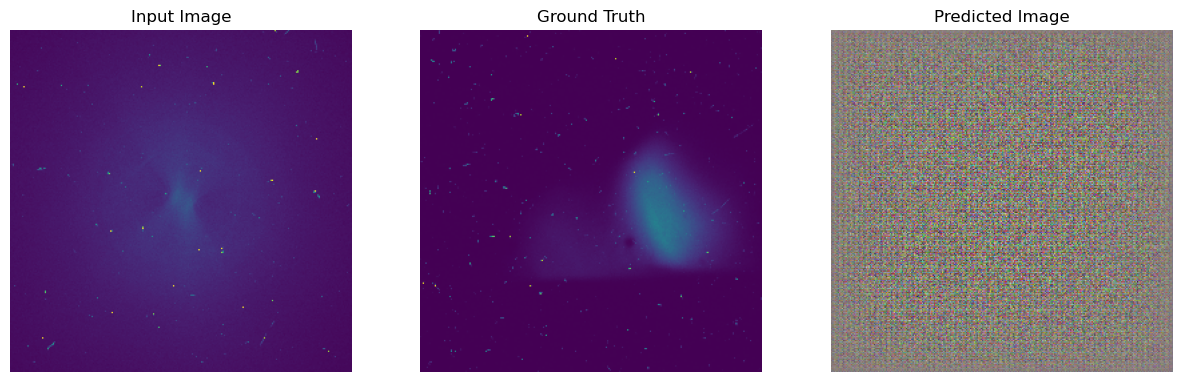

In [18]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True) # when on testset, this has to be set as false
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):  # present the result in a nice visual way
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    
    
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

# Model Training

In [19]:

from IPython.display import display, clear_output
import IPython


log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # first get each output from the Generator and discriminator (three in total)
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        # based on the output, calculate the loss respectively
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    # using SGD propogate the loss back to the network to update the weights
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    # save the loss history
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
        
        
        
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            IPython.display.clear_output(wait=True)
            
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps, disable if it consume too much space
        # if (step + 1) % 5000 == 0:
        #    checkpoint.save(file_prefix=checkpoint_prefix)
    print('training complete!')
            


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

Time taken for 1000 steps: 569.21 sec



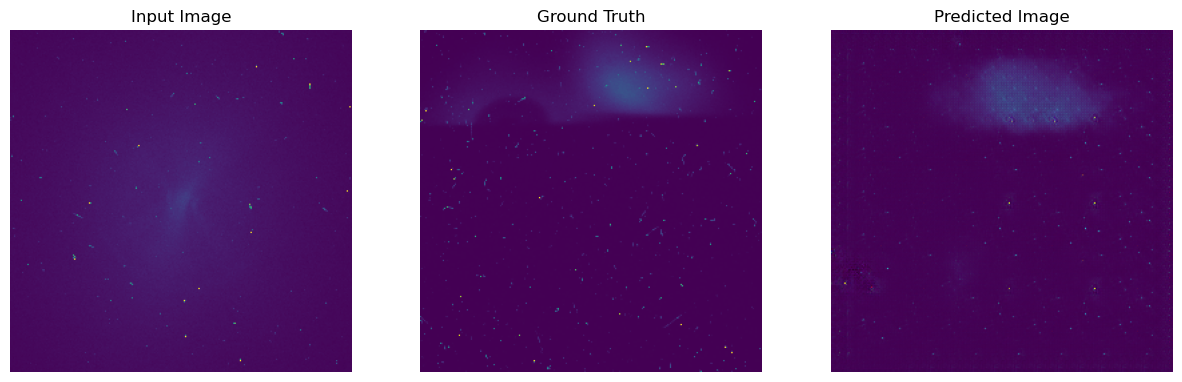

Step: 39k
....................................................................................................training complete!


In [20]:
'''Start training the model'''
# if the total training set is 800, since they recommand batch size of 1 image, so 40,000 steps is equal to 50 epochs.

fit(train_dataset, test_dataset, steps=40000)
print('training completed!')

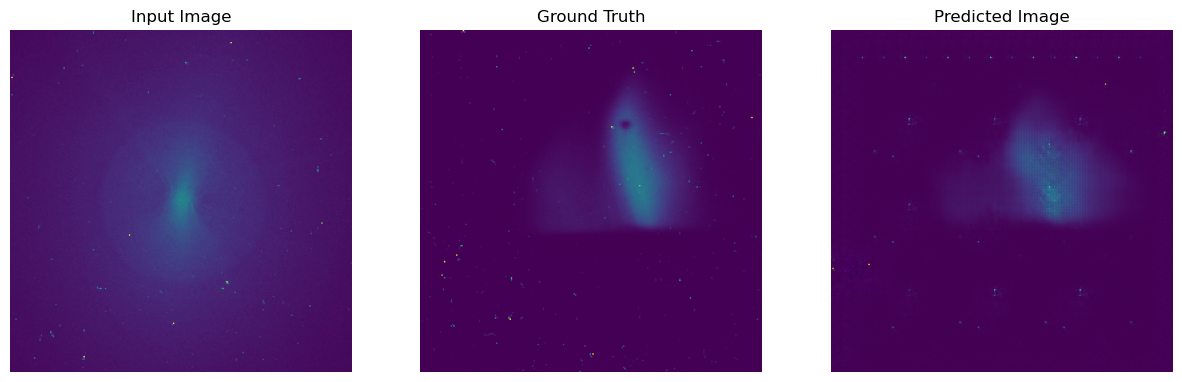

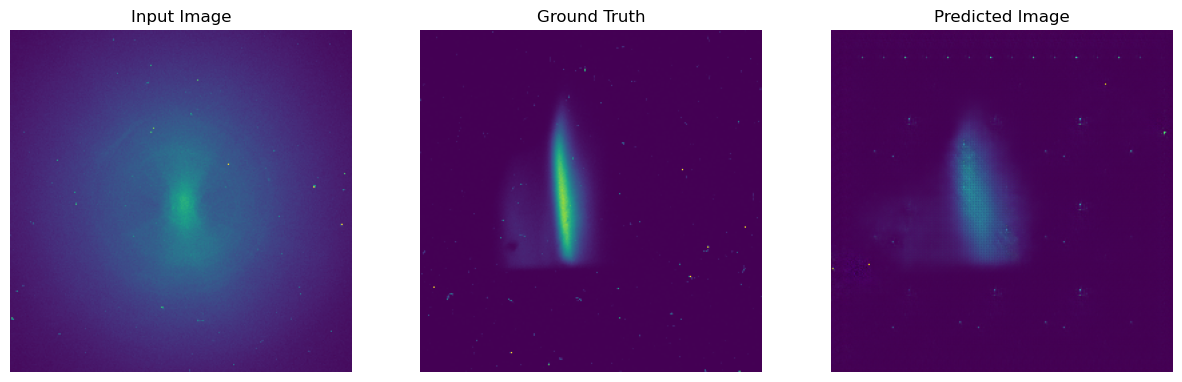

In [23]:
# Run the trained model on a few examples from the test set

for inp, tar in test_dataset.take(2):
    generate_images(generator, inp, tar)


# Save the final model

In [24]:
'''save the latest model，be careful don't overwrite the model !!!'''

generator.save('models/pix2pix.keras')

In [2]:
# Load the trained model

model_saved = tf.keras.models.load_model('models/pix2pix.keras')
model_saved.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 64, 64, 128)          131584    ['sequential_2[0][0]']        
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 32, 128)          262656    ['sequential_3[0][0]']        
                                                                                           

In [3]:
# test the saved model on testset

for inp, tar in test_dataset.take(2):
    model_saved(generator, inp, tar)

NameError: name 'test_dataset' is not defined

# Training history

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

def read_tensorflow_logs(logdir):
    metrics = {}
    for event_file in tf.io.gfile.glob(f"{logdir}/*"):
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag not in metrics:
                    metrics[v.tag] = []
                metrics[v.tag].append(v.simple_value)
    return metrics

def plot_metrics(metrics, metric_names):
    plt.figure(figsize=(10, 5))
    for name in metric_names:
        if name in metrics:  # Check if the metric name exists
            epochs = range(1, len(metrics[name]) + 1)
            plt.plot(epochs, metrics[name], label=name)
        else:
            print(f"Metric '{name}' not found in logs.")
    plt.title('Training Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()




In [3]:
# Example usage
logdir = 'logs/fit/20240130-081446/events.out.tfevents.1706602486.MWS-1048406.11204.0.v2'
metrics = read_tensorflow_logs(logdir)

# Before plotting, print available metric names
print("Available metric names:", list(metrics.keys()))

# Adjust metric names based on the available ones
plot_metrics(metrics, ['loss', 'val_loss'])  # Adjust 'loss' and 'val_loss' as needed



Available metric names: []


KeyError: 'loss'

<Figure size 1000x500 with 0 Axes>

In [8]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb





major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)


experiment_id = "c1KCv3X3QvGwaXfgX1c4tg"
experiment = tf.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df








TensorBoard version:  2.15.1


AttributeError: module 'tensorflow._api.v2.data.experimental' has no attribute 'ExperimentFromDev'